# TF-IDF.

TF-IDF - term frequency - inverse document frequency - один з способів оцінки важливості слова у документі. Вага tf-idf - це вага, яка використовується при отриманні інформації та аналізу текстів. Ця вага є статистичним показником, який використовується для оцінки важливості слова для документа в колекції або корпусі. Важливість слова зростає пропорційно до кількості разів появи слова у документі або компенсується частотою слова в корпусі. Варіанти схем зважування tf-idf часто використовуються пошуковими системами як центральний інструмент оцінки та ранжування  важливості документа при отриманому запиті від користувача.

Корпус - це колекція текстів.

Одна з найпростіших функцій ранжування обраховується як просте сумування tf-idf для кожного запиту. Окрім того існує багато інших складніших методів ранжування функцій.

Зазвичай tf-idf вага складається з двох складових - спочатку обраховується нормалізована Частота Терміну (Term Frequency TF), або відношення кількість разів появи слова у документі до загальної кількість слів у документів. Друга складова - Зворотня Частота Документу (Inverse Documnet Frequency IDF), яка обраховується як відношення логарифму кількості документів у корпусі до кількості документів, де зустрічається вказаний термін.

__TF: Term Frequency__ - визначає, наскільки часто термін зустрічається в документі. Оскільки документи мають різну довжину, є ймовірність того, що термін буде виникати у довгих документах частіше, ніж у коротких. Тому, як спосіб нормалізації, частота терміну часто ділиться на загальну кількість слів у документі. 

__IDF: Inverse Document Frequency__ - визначає, наскільки важливим є термін. Обраховуючи TF, всі терміни розглядаються як такі, які мають однакову важливість. Однак, різні допоміжні слова можуть виникати часто, але мати маленьку важливість. Тому необхідно зменшити вагу термінів, які зустрічаються часто і збільшити вагу для термінів, які зустрічаються рідко.

Розглянемо приклад. Використаємо набір даних з [UCI](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection).

In [1]:
messages = [line.rstrip() for line in open('SMSSpamCollection')]
print(len(messages))

5574


In [2]:
for message_no, message in enumerate(messages[:10]):
    print(message_no, message)

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
1 ham	Ok lar... Joking wif u oni...
2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3 ham	U dun say so early hor... U c already then say...
4 ham	Nah I don't think he goes to usf, he lives around here though
5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
6 ham	Even my brother is not like to speak with me. They treat me like aids patent.
7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
8 spam	WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 

Тут ми бачимо, що першим елементом у повідомленні є мітка, чи це повідомлення є нормальним (ham) чи спамом (spam). Друга частина - це саме повідомлення.

Використовуючи помічені дані, ми натренуємо модель, яка зможе автоматично розрізняти нормальні повідомлення від спаму. Потім, вже натреновану модель можна буде використовувати, щоб класифікувати дані без міток.

In [3]:
import pandas as pd

messages = pd.read_csv('SMSSpamCollection', sep='\t', names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Аналіз даних.

In [4]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Під час аналізу даних потрібно вибирати властивості, які будуть використовуватись у подальшому. Це також відповідає ідеї [розробки властивостей](https://en.wikipedia.org/wiki/Feature_engineering). Чим кращі знання розробника у досліджуваній сфері, тим більше властивостей він зможе створити з наявних даних.

In [5]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

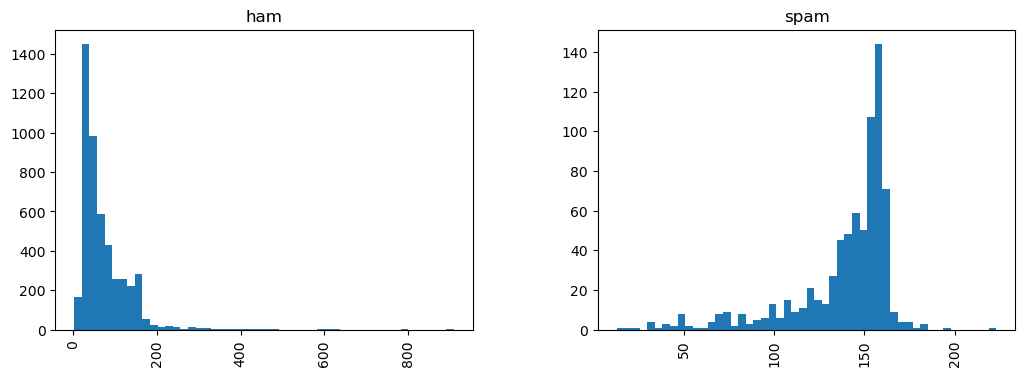

In [7]:
messages.hist(column='length', by='label', bins=50,figsize=(12,4))

Тут ми можемо побачити, що повідомлення спаму переважно мають більшу кількість символів.

## Попередня обробка даних.
Найбільша проблема у роботі з текстами це те, що всі дані мають тип string. Всі класифікаційні алгоритми потребують дані у числовому векторному форматі. Існують різні методи для перетворення корпусу у векторний формат. Найпростішим є [сумка слів](https://en.wikipedia.org/wiki/Bag-of-words_model), у якому кожному унікальному слову відповідає одне число.

У цьому випадку розглянемо перетворення послідовності символів у послідовність чисел.

Для початку створимо функцію, яка видалить з даних всі розділові знаки та стоп слова.

In [8]:
import string
from nltk.corpus import stopwords

In [9]:
def process_text(source):
    nopunc = [char for char in source if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [10]:
process_text("Simple message. It has punctuation!")

['Simple', 'message', 'punctuation']

Після цього, проведемо так звану "токенізацію" повідомлень у наборі даних. Токенізація - це процес перетворення звичайних string повідомлень у список токенів (слів, які потрібні для подальшої роботи).

In [11]:
messages['message'].head(5).apply(process_text)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

## Векторизація.
У цьому випадку використаємо простий підхід з використанням сумки слів:
1. Обрахуєм кількість появи слова у кожному повідомленні;
2. Зважимо обрахунки, щоб терміни, які зустрічаються частіше, мали меншу вагу;
3. Нормалізувємо вектори до одиниці довжини, щоб абстрагуватись від початкової довжини тексту.

Кожен вектор буде мати таку розмірність, скільки унікальних слів є у всьому корпусі. Для виконання цього кроку використаємо __CountVectorizer__, який перетворить колекцію текстових документів у матрицю з підрахунком токенів. Результат виконання цього кроку можна уявити як двовимірну матрицю, де одним з вимірів буде словник усіх слів, які використовуються у повідомленнях, а іншим виміром будуть повідомилення з набору даних.
Оскільки в наборі даних є багато повідомлень, варто очікувати багато нулів у обрахунках присутності слів у документах. Через це у результаті буде отримана [розріджена матриця.](https://en.wikipedia.org/wiki/Sparse_matrix).

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
bow_transformer = CountVectorizer(analyzer=process_text).fit(messages['message'])

print(len(bow_transformer.vocabulary_))

11425


Тепер можна провести трансформацію усіх повідомлень у наборі даних.

In [14]:
messages_bow = bow_transformer.transform(messages['message'])

In [15]:
print('Shape of Sparse Matrix: ', messages_bow.shape)
print('Amount of Non-Zero occurences: ', messages_bow.nnz)

Shape of Sparse Matrix:  (5572, 11425)
Amount of Non-Zero occurences:  50548


In [16]:
sparsity = (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1]))
print('sparsity: {}'.format(round(sparsity)))

sparsity: 0


## Використання TF-IDF.
Після векторизації, зважування та нормалізація термінів може бути виконана використовуючи [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).

In [17]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer().fit(messages_bow)
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5572, 11425)


## Тренування моделі.
Тепер, коли дані є репрезентовані як вектори, можна натренувати модель для класифікації повідомлень. Використаємо Наївний Баєсівський класифікатор.

In [18]:
from sklearn.naive_bayes import MultinomialNB
spam_detect_model = MultinomialNB().fit(messages_tfidf, messages['label'])

## Оцінка моделі.

In [19]:
all_predictions = spam_detect_model.predict(messages_tfidf)
print(all_predictions)

['ham' 'ham' 'spam' ... 'ham' 'ham' 'ham']


In [20]:
from sklearn.metrics import classification_report
print(classification_report(messages['label'], all_predictions))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      4825
        spam       1.00      0.85      0.92       747

    accuracy                           0.98      5572
   macro avg       0.99      0.92      0.95      5572
weighted avg       0.98      0.98      0.98      5572



In [21]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(messages['label'], all_predictions))

[[4825    0]
 [ 115  632]]


Тут, для демонстративних цілей, оцінка була проведена на тих самих даних, на яких і відбувалось тренування. Насправді, так робити не варто, оскільки це не дає повного розуміння, як модель буде працювати на нових даних.

## Поділ даних на тренувальний та тестовий набір.

In [22]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = train_test_split(messages['message'], messages['label'], test_size=0.2)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4457 1115 5572


## Використання pipeline-у для роботи.
Тут використаємо можливості [pipeline](https://scikit-learn.org/stable/modules/compose.html) для того, щоб зберегти порядок роботи. Це дозволить налаштувати всі трансформації даних для майбутнього використання.

In [23]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=process_text)),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB()),
])

In [24]:
pipeline.fit(msg_train, label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function process_text at 0x00000226969565E0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [25]:
predictions = pipeline.predict(msg_test)

In [26]:
print(classification_report(predictions, label_test))

              precision    recall  f1-score   support

         ham       1.00      0.96      0.98       993
        spam       0.77      1.00      0.87       122

    accuracy                           0.97      1115
   macro avg       0.89      0.98      0.93      1115
weighted avg       0.98      0.97      0.97      1115



In [27]:
print(confusion_matrix(predictions, label_test))

[[957  36]
 [  0 122]]
